# Forcasting H0 constraints with lensed SNe
This notebook is meant to forecast future constraints with lensed supernovae to break the MST.


To run the notebook, the following software is required:
- hierArc: https://github.com/sibirrer/hierArc (main branch)
- lenstronomy: https://github.com/sibirrer/lenstronomy (main branch)
- corner: https://github.com/dfm/corner.py
- emcee: https://github.com/dfm/emcee

Author: Simon Birrer (sibirrer@gmail.com)

The forecast is compared with a mock sample mimicing the TDCOSMO IV results using kinematics and an external sample of lenses to break the MST.

In [1]:
# import standard python modules
import numpy as np
import time
import corner
import copy
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

# import lenstronomy and hierArc modules
from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.PointSource.point_source import PointSource
from lenstronomy.Plots import plot_util
from lenstronomy.Plots import chain_plot, lens_plot
from lenstronomy.Util import constants as const
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Sampling.parameters import Param
from lenstronomy.Util.data_util import magnitude2cps

from hierarc.Likelihood.anisotropy_scaling import AnisotropyScalingIFU
from hierarc.Sampling.ParamManager.cosmo_param import CosmoParam
from hierarc.Sampling.mcmc_sampling import MCMCSampler

# matplotlib configs
from pylab import rc
rc('axes', linewidth=2)
rc('xtick',labelsize=15)
rc('ytick',labelsize=15)

np.random.seed(7)

path = os.getcwd()
dirname = os.path.dirname(path)


## Sne-only analysis

We are using the Pantheon sample to constrain the relative expansion history with SN Ia's and to determin the apparent magnitudes of the population of supernovae.

In [2]:
# ==========================
# COSMOLOGY SAMPLING OPTIONS
# ==========================

# currently supported models within hierArc: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'

# we are sampling a flat LCDM cosmology with parameters 'h0' and 'om' as an example
cosmology = 'FLCDM'

kwargs_lower_cosmo = {'h0': 0, 'om': 0.05}  # lower bounds on cosmology parameters
kwargs_upper_cosmo = {'h0': 150, 'om': 0.5}  # upper bounds on cosmology parameters
kwargs_cosmo_start_mean = {'h0': 70, 'om': 0.3}  # mean start particles
kwargs_cosmo_start_sigma = {'h0': 10, 'om': 0.1}  # width of start particles

# we add the apparent source magnitude at z=0.1 (pivot normalization) (mean of Gaussian distribution in astronomical magnitudes)
z_apparent_m_anchor = 0.1
apparent_m_z01 = 18.963196264371216

kwargs_lower_source = {'mu_sne': apparent_m_z01-20, 'sigma_sne': 0.}  # lower bounds on cosmology parameters
kwargs_upper_source = {'mu_sne': apparent_m_z01+20, 'sigma_sne': 2}  # upper bounds on cosmology parameters
kwargs_source_start_mean = {'mu_sne': apparent_m_z01, 'sigma_sne': 0.2}  # mean start particles
kwargs_source_start_sigma = {'mu_sne': 1, 'sigma_sne': 0.2}  # width of start particles


kwargs_mean_start_sne = {'kwargs_cosmo': kwargs_cosmo_start_mean, 'kwargs_source': kwargs_source_start_mean}
kwargs_sigma_start_sne = {'kwargs_cosmo': kwargs_cosmo_start_sigma, 'kwargs_source': kwargs_source_start_sigma}



# these values are held fixed throughout the entire sampling (optinal to add here)
kwargs_fixed_cosmo_sne = {} # {'h0': 70}
kwargs_fixed_source_sne = {'sigma_sne': 0}

kwargs_bounds_sne = {'kwargs_lower_cosmo': kwargs_lower_cosmo,
                     'kwargs_upper_cosmo': kwargs_upper_cosmo,
                     'kwargs_fixed_cosmo': kwargs_fixed_cosmo_sne,
                     'kwargs_lower_source': kwargs_lower_source,
                     'kwargs_upper_source': kwargs_upper_source,
                     'kwargs_fixed_source': kwargs_fixed_source_sne,
                }

mcmc_sampler_sne = MCMCSampler(kwargs_likelihood_list=[], cosmology=cosmology, 
                               sne_likelihood='Pantheon', # we are using the Pantheon sample as the likelihood
                               sne_apparent_m_sampling=True, # we sample the apparent magnitude (this is optional, to test for incorporanting Sne magnitudes in the strong lensing analysis)
                               sne_distribution='NONE',  # we do not add distribution parameter of the apparent magnitudes at fixed redshift (becomes only relevant for the SL analysis)
                               kwargs_bounds=kwargs_bounds_sne,
                               z_apparent_m_anchor=z_apparent_m_anchor,
                               interpolate_cosmo=True, num_redshift_interp=100)

100%|██████████| 600/600 [02:43<00:00,  3.50it/s]


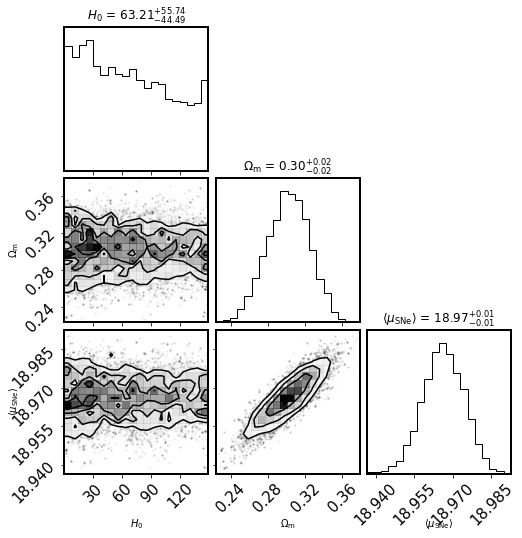

In [3]:
# =============================
# EMCEE SAMPLING CONFIGURATIONS
# =============================

# file name of chains. ATTENTION!!! Do not store them in version control and chose a different path!



# Set up the backend
# Don't forget to clear it in case the file already exists
#backend_sne = emcee.backends.HDFBackend(filename_sne)
    
# these configs are such that you can locally execute it in few hours, not meant to provide converged chains!
kwargs_emcee_sne = {'n_walkers': 50,  # number of walkers
                'n_run': 200,  # number of iterations saved in the file
                'n_burn': 400,  # number of iterations as burn-in prior to start saving the chain
                'pool': None,  # (option) emcee pool for multi-threading or MPI, see e.g. emcee documentation or usage in lenstronomy
                'continue_from_backend': False,  # boolean, if True, continues sampling the emcee chain from a backend (if exists), otherwise deletes previous chains and starts from scratch
                'kwargs_mean_start': kwargs_mean_start_sne,  # starting positions as configured
                'kwargs_sigma_start': kwargs_sigma_start_sne,  # starting position as configured
                #'backend': backend_sne,
               }

mcmc_samples_sne, log_prob_sne = mcmc_sampler_sne.mcmc_emcee(**kwargs_emcee_sne)

corner.corner(mcmc_samples_sne, show_titles=True, labels=mcmc_sampler_sne.param_names(latex_style=True))
plt.show()



## Model setting
Here we define the cosmological model and the population parameters to be constrainted in the hierarchical analysis. We make these parameter match the Pantheon inference with the same cosmological model, thus allowing us to use the Pantheon sample in our forecast as an option.

In [30]:
cosmology = 'FLCDM'  # Flat LCDM cosmology
kwargs_cosmo_true = {'h0': 70, 'om': 0.3}  # cosmological model of the forecast

# we use the mean inferred apparent magnitude of the Pantheon sample
index_mag = 2  # index of mu_sne magnitude parameter in the SNe-only fit
apparent_m_z = np.mean(mcmc_samples_sne[:, index_mag])

# Prior on Omega_m
sigma_om = 0.022  # thight prior on Om based on the Pantheon flat LCDM constraints

lambda_int_true_mean = 0.9  # true (assumed for testing) sample mean internal MST transform
lambda_int_true_sigma = .03  # true (assumed for testing) sample 1-sigma scatter of internal MST transform

lambda_mst_distribution = 'GAUSSIAN'  # 'delta' #'GAUSSIAN'  # single-valued distribution in the MST transform on top of a power-law model
kwargs_lens_true = {'lambda_mst': lambda_int_true_mean}
if lambda_mst_distribution == 'GAUSSIAN':
    kwargs_lens_true['lambda_mst_sigma'] = lambda_int_true_sigma

# create astropy.cosmology instance of input cosmology
cosmo_param = CosmoParam(cosmology=cosmology)
cosmo_true = cosmo_param.cosmo(kwargs_cosmo_true)

def draw_lambda_int_true():
    if lambda_mst_distribution == 'delta':
        return lambda_int_true_mean
    else:
        return np.random.normal(lambda_int_true_mean, lambda_int_true_sigma)

    
# ==============================
# SNe scenario
# ==============================


# SNe intrinsic (peak) brightness distribution (including micro and milli-lensing contributions)
mu_sne_true = apparent_m_z  # apparent magnitude (mean in magnitude) at pivot redshift
sigma_sne_true = 0.1  # 1-sigma with of Gaussian in astronomical magnitude

kwargs_source_true = {'mu_sne': mu_sne_true, 'sigma_sne': sigma_sne_true}




# Forecast settings
In this block we specify the sample number and their uncertainties in kinematics observations, lens model as well as their distributions.

/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:49: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


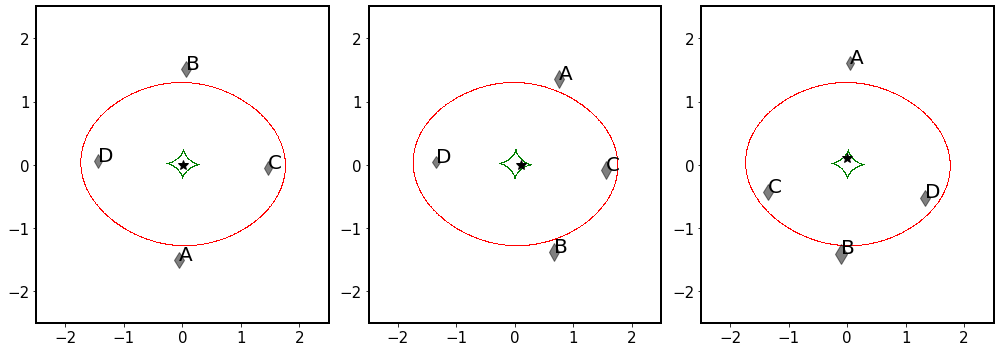

In [5]:
# ==============================================================================
# Lens model
# ==============================================================================

re_compute_lens_posterior = False
path2posteriors = os.path.join(dirname, 'Data')

# Here we define Einstein radius, power-law slope and half light radius of the deflector - and their uncertainties. 
# In this forecast, for simplicity, we assume that all lenses are identical in these parameters to re-utilize the dimensionless kinematics prediction for all lenses.

# lens and light model parameters and uncertainties (used for kinematic modeling uncertainties)
theta_E, theta_E_error = 1.5, 0.02  # Einstein radius
gamma, gamma_error = 2.0, 0.03  # power-law slope of the mass profile
# Xuhengs paper 0.01X ?


lens_model_list = ['EPL', 'SHEAR']
point_source_model = ['SOURCE_POSITION']
lens_model = LensModel(lens_model_list=lens_model_list)



# define lens model and source position
kwargs_lens = [{'theta_E': theta_E, 'gamma': gamma, 'e1': 0.2, 'e2': -0.01, 'center_x': 0, 'center_y': 0},
                   {'gamma1': 0.05, 'gamma2': 0.}]

kwargs_lens_plot = {'with_caustics': True, 'fast_caustic': True, 'point_source': True,
                   'with_convergence': False}

f, axex = plt.subplots(1, 3, figsize=(14, 5))

# cross
kwargs_ps_cross = [{'ra_source': 0, 'dec_source': 0}]
lens_plot.lens_model_plot(axex[0], lens_model, kwargs_lens, numPix=500, deltaPix=0.01, 
                          sourcePos_x=kwargs_ps_cross[0]['ra_source'], sourcePos_y=kwargs_ps_cross[0]['dec_source'], **kwargs_lens_plot)


# cusp
kwargs_ps_cusp = [{'ra_source': 0.1, 'dec_source': 0}]
lens_plot.lens_model_plot(axex[1], lens_model, kwargs_lens, numPix=500, deltaPix=0.01, 
                          sourcePos_x=kwargs_ps_cusp[0]['ra_source'], sourcePos_y=kwargs_ps_cusp[0]['dec_source'], **kwargs_lens_plot)


# fold
kwargs_ps_fold = [{'ra_source': 0., 'dec_source': 0.1}]
lens_plot.lens_model_plot(axex[2], lens_model, kwargs_lens, numPix=500, deltaPix=0.01, 
                          sourcePos_x=kwargs_ps_fold[0]['ra_source'], sourcePos_y=kwargs_ps_fold[0]['dec_source'], **kwargs_lens_plot)
f.tight_layout()
f.show()
# perform inference on Fermat potential and magnification

In [6]:

# ==============================
# Redshift distribution
# ==============================


def draw_redshift():
    """
    distribution of lens and source redshift to be drawn from (the same except for the current TDCOSMO sample)
    """
    z_lens = np.random.uniform(low=0.1, high=0.6)
    z_source = np.random.uniform(low=z_lens+0.2, high=3)
    return z_lens, z_source


# ==============================
# SNe scenario
# ==============================


# SNe intrinsic (peak) brightness distribution (including micro and milli-lensing contributions)
magnitude_zero_point = 30  # magnitude zero point in which the flux counts are expressed in the measured brightness 

num_sne_cusp = 5  # number of lensed SNe
num_sne_cross = 5  # number of lensed SNe
num_sne_fold = 5  # number of lensed SNe

flux_precision = 0.1  # relative precision of individual flux/normalization measurement
time_delay_precision = 1.  # precision in time-delay measurement from SNe in units of days (1-sigma)
astrometric_precision = 0.005  # astrometric precision of the images of the multiply lensed SNe in arc seconds




def draw_amp_source(z_source, cosmo):
    """
    draw an apparent unlensed brightness of a SN at given redshift
    """
    # draw apparent magnitude as at pivot redshift
    mag_source_pivot = np.random.normal(mu_sne_true, sigma_sne_true)
    # compute relative luminosity distance between pivot redshift and source redshift
    
    angular_diameter_distance_source = cosmo.angular_diameter_distance(z_source).value
    lum_dist_source = (5 * np.log10((1 + z_source) * (1 + z_source) * angular_diameter_distance_source))

    z_pivot = z_apparent_m_anchor
    ang_dist_pivot = cosmo.angular_diameter_distance(z_pivot).value
    lum_dist_pivot = (5 * np.log10((1 + z_pivot) * (1 + z_pivot) * ang_dist_pivot))
    delta_mag = lum_dist_source - lum_dist_pivot
    
    mag_source = mag_source_pivot + delta_mag
    amp_source = magnitude2cps(mag_source, magnitude_zero_point)
    return amp_source
    

# draw lenses
def true_lens_sne(kwargs_lens, kwargs_ps):
    """
    compute observables for the given lens model with the source-lens redshift configuration drawn from a distribution
    """
    # compute image positions, time delays and magnifications
    # draw redshifts
    z_lens, z_source = draw_redshift()
    lens_cosmo = LensCosmo(z_lens, z_source, cosmo_true)
    amp_source = draw_amp_source(z_source, cosmo_true)
    lambda_int = draw_lambda_int_true()
    
    lensModel = LensModel(lens_model_list=lens_model_list, z_lens=z_lens, z_source=z_source, cosmo=cosmo_true)
    psModel = PointSource(point_source_type_list=point_source_model, lensModel=lensModel)
    num_image = 0
    mag_max = 20

    x_pos, y_pos = psModel.image_position(kwargs_ps, kwargs_lens)
    x_image, y_image = x_pos[0], y_pos[0]  # only chose the first point source model (includes all images)
    mag_model = lensModel.magnification(x_image, y_image, kwargs_lens)
    mag_model = np.abs(mag_model)
    amp = mag_model / lambda_int**2 * amp_source
    arrival_time = lensModel.arrival_time(x_image, y_image, kwargs_lens, kappa_ext=0) * lambda_int
    fermat_pot_pl = lensModel.fermat_potential(x_image, y_image, kwargs_lens)# * lambda_int
    fermat_pot_pl_diff = fermat_pot_pl[1:] - fermat_pot_pl[0]
    time_delay_diff = arrival_time[1:] - arrival_time[0]
    return amp, mag_model, time_delay_diff, fermat_pot_pl_diff, x_image, y_image, z_lens, z_source, lambda_int


# compute covariance matrix

# likelihood setting
def draw_lens_measured(amp, time_delay, x_image, y_image):
    """
    add measurement errors and return a realization of the measurement with the covariance matrices
    """

    cov_td_measured = np.ones((len(time_delay), len(time_delay))) * time_delay_precision**2  # fully covariant time delay measurement uncertainties
    cov_amp_measured = np.diag((amp * flux_precision)**2)
    time_delay_measured = np.random.multivariate_normal(time_delay, cov_td_measured)
    amp_measured = np.random.multivariate_normal(amp, cov_amp_measured)
    x_image_measured = np.random.normal(x_image, astrometric_precision)
    y_image_measured = np.random.normal(y_image, astrometric_precision)
    return time_delay_measured, cov_td_measured, amp_measured, cov_amp_measured, x_image_measured, y_image_measured
    


def model_errors(x_image_measured, y_image_measured, kwargs_lens, kwargs_ps):
    """
    run a lens model inference to compute Fermat potential and magnification estimates and their error covariance matrix
    """
    kwargs_data_joint = {'ra_image_list': [x_image_measured], 'dec_image_list': [y_image_measured]}
    # set up likelihood with gamma prior and image position likelihood
    # ==================

    fixed_lens = [{}, {'ra_0': 0, 'dec_0': 0}]
    kwargs_lens_init = kwargs_lens
    kwargs_lens_sigma = [{'theta_E': .1, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1, 'center_x': 0.1, 'center_y': 0.1}, {'gamma1': 0.1, 'gamma2': 0.1}]
    kwargs_lower_lens = [{'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.5, 'center_x': -10, 'center_y': -10}, {'gamma1': -0.3, 'gamma2': -0.3}]
    kwargs_upper_lens = [{'theta_E': 10, 'e1': 0.5, 'e2': 0.5, 'gamma': 2.5, 'center_x': 10, 'center_y': 10}, {'gamma1': 0.3, 'gamma2': 0.3}]
    # combine all parameter options for lenstronomy
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    # =========================
    # image position parameters
    # =========================

    # we chose to model the image positions in the lensed plane (we know where they appear)
    point_source_list = ['LENSED_POSITION']
    # We fix the image position coordinates.
    fixed_ps = [{}]  # we fix the image position coordinates
    # these lines below actually don't matter when you keep the image position fixed
    kwargs_ps_init = [{'ra_image': x_image_measured, 'dec_image': y_image_measured}] # the initial guess for the appearing image positions is: at the image position.
    kwargs_ps_sigma = [{'ra_image': 0.01 * np.ones(len(x_image_measured)), 'dec_image': 0.01 * np.ones(len(x_image_measured))}]
    kwargs_lower_ps = [{'ra_image': -10 * np.ones(len(x_image_measured)), 'dec_image': -10 * np.ones(len(x_image_measured))}]
    kwargs_upper_ps = [{'ra_image': 10* np.ones(len(x_image_measured)), 'dec_image': 10 * np.ones(len(x_image_measured))}]
    # combine all parameter options for lenstronomy
    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]


    # combined parameter settings
    kwargs_params = {'lens_model': lens_params,
                    'point_source_model': ps_params}

    # our model choices
    kwargs_model = {'lens_model_list': lens_model_list, 
                    'point_source_model_list': point_source_list
                     }

    image_position_likelihood = True  # bool, evaluating the image position likelihood (in combination with astrometric errors)

    kwargs_constraints = {'num_point_source_list': [len(x_image_measured)]}

    # we can define un-correlated Gaussian priors on specific parameters explicitly
    # e.g. power-law mass slope of the main deflector
    prior_lens = [[0, 'gamma', gamma, gamma_error], [0, 'center_x', 0, 0.01], [0, 'center_y', 0, 0.01], [0, 'e1', kwargs_lens[0]['e1'], 0.01], [0, 'e2', kwargs_lens[0]['e2'], 0.01], [1, 'gamma1', kwargs_lens[1]['gamma1'], 0.01], [1, 'gamma2', kwargs_lens[1]['gamma2'], 0.01]] # [[index_model, 'param_name', mean, 1-sigma error], [...], ...]

    kwargs_likelihood = {  
                         'image_position_uncertainty': astrometric_precision,  # astrometric uncertainty of image positions
                         'image_position_likelihood': True, # evaluate point source likelihood given the measured image positions
                         'prior_lens': prior_lens,
                         'check_bounds': True,  # check parameter bounds and punish them
                        }
    
    # setting the non-linear solver accoring to option (3)
    kwargs_constraints['solver_type'] = 'PROFILE_SHEAR'  # 'PROFILE_SHEAR', 'NONE', # any proposed lens model must satisfy the image positions appearing at the position of the point sources being sampeled

    # checking for matched source position in ray-tracing the image position back to the source plane.
    # This flag should be set =True when dealing with option (2) and (3)
    kwargs_likelihood['check_matched_source_position'] = True  # check non-linear solver and disgard non-solutions
    kwargs_likelihood['source_position_tolerance'] = 0.01  # hard bound tolerance on r.m.s. scatter in the source plane to be met in the sampling

    # desired precision on r.m.s. scatter in the source plane to achive. 
    # This is implemented as a Gaussian likelihood term and is met when the model is sufficient in describing the data
    # This precision must be set when using option (2). Option (3) should guarantee a very high precision except in some failurs of the solver.
    kwargs_likelihood['source_position_sigma'] = 0.001

    # setting to propagate the astrometric uncertainties in image position into a likelihood in the source position.
    # Option (4) above. This option can be used SEPARATE to the solver or the source position tolerance (see below)
    # This is not recommended when requiring time-delay predictions.
    kwargs_likelihood['source_position_likelihood'] = False  # evaluates how close the different image positions match the source positons]

    fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)

    fitting_kwargs_list = [
        #['PSO', {'sigma_scale': 1., 'n_particles': 200, 'n_iterations': 500}], # we already know the solution so no need to fit it
        ['MCMC', {'n_burn': 400, 'n_run': 400, 'walkerRatio': 10,'sigma_scale': 0.1}]]

    start_time = time.time()
    kwargs_result = fitting_seq.best_fit()
    chain_list = fitting_seq.fit_sequence(fitting_kwargs_list)
    end_time = time.time()
    print(end_time - start_time, 'total time needed for computation')
    print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')
    #for i in range(len(chain_list)):
    #    chain_plot.plot_chain_list(chain_list, i)

    sampler_type, samples_mcmc, param_mcmc, dist_mcmc  = chain_list[0]
    
    param = Param(kwargs_model, fixed_lens, kwargs_fixed_ps=fixed_ps, 
                  kwargs_lens_init=kwargs_result['kwargs_lens'], **kwargs_constraints)
    lensModel = LensModel(kwargs_model['lens_model_list'])
    mcmc_new_list = []
    
    for i in range(len(samples_mcmc)):
        # transform the parameter position of the MCMC chain in a lenstronomy convention with keyword arguments #
        kwargs_out = param.args2kwargs(samples_mcmc[i])
        kwargs_lens_out, kwargs_ps_out = kwargs_out['kwargs_lens'], kwargs_out['kwargs_ps']
        x_pos, y_pos = kwargs_ps_out[0]['ra_image'], kwargs_ps_out[0]['dec_image']
        mag = lensModel.magnification(x_pos, y_pos, kwargs_lens_out)
        mag = np.abs(mag)
        mag[mag > 100] = 100
        fermat_pot = lensModel.fermat_potential(x_pos, y_pos, kwargs_lens_out)
        delta_fermat = fermat_pot[1:] - fermat_pot[0]
        new_chain = np.append(delta_fermat, mag)
        mcmc_new_list.append(new_chain)
    
    return np.array(mcmc_new_list)

    
    # run MCMC
    # process MCMC samples in Fermat potential differences and magnification

In [7]:
lensModel = LensModel(lens_model_list=lens_model_list)
psModel = PointSource(point_source_type_list=point_source_model, lensModel=lensModel)

# cross
x_pos, y_pos = psModel.image_position(kwargs_ps_cross, kwargs_lens)
x_image_cross, y_image_cross = x_pos[0], y_pos[0]
cross_file = os.path.join(path2posteriors, 'mcmc_chain_cross.npy')
if re_compute_lens_posterior:
    mcmc_chain_cross = model_errors(x_image_cross, y_image_cross, kwargs_lens, kwargs_ps_cross)
    np.save(cross_file, mcmc_chain_cross)
else:
    mcmc_chain_cross = np.load(cross_file)
cov_model_cross = np.cov(mcmc_chain_cross.T)

# cusp
x_pos, y_pos = psModel.image_position(kwargs_ps_cusp, kwargs_lens)
x_image_cusp, y_image_cusp = x_pos[0], y_pos[0]
cusp_file = os.path.join(path2posteriors, 'mcmc_chain_cusp.npy')
if re_compute_lens_posterior:
    mcmc_chain_cusp = model_errors(x_image_cusp, y_image_cusp, kwargs_lens, kwargs_ps_cusp)
    np.save(cusp_file, mcmc_chain_cusp)
else:
    mcmc_chain_cusp = np.load(cusp_file)
cov_model_cusp = np.cov(mcmc_chain_cusp.T)

# fold
x_pos, y_pos = psModel.image_position(kwargs_ps_fold, kwargs_lens)
x_image_fold, y_image_fold = x_pos[0], y_pos[0] 
fold_file = os.path.join(path2posteriors, 'mcmc_chain_fold.npy')
if re_compute_lens_posterior:
    mcmc_chain_fold = model_errors(x_image_fold, y_image_fold, kwargs_lens, kwargs_ps_fold)
    np.save(fold_file, mcmc_chain_fold)
else:
    mcmc_chain_fold = np.load(fold_file)
cov_model_fold = np.cov(mcmc_chain_fold.T)



/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:33: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:34: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:41: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:47: MatplotlibDeprecationWarni

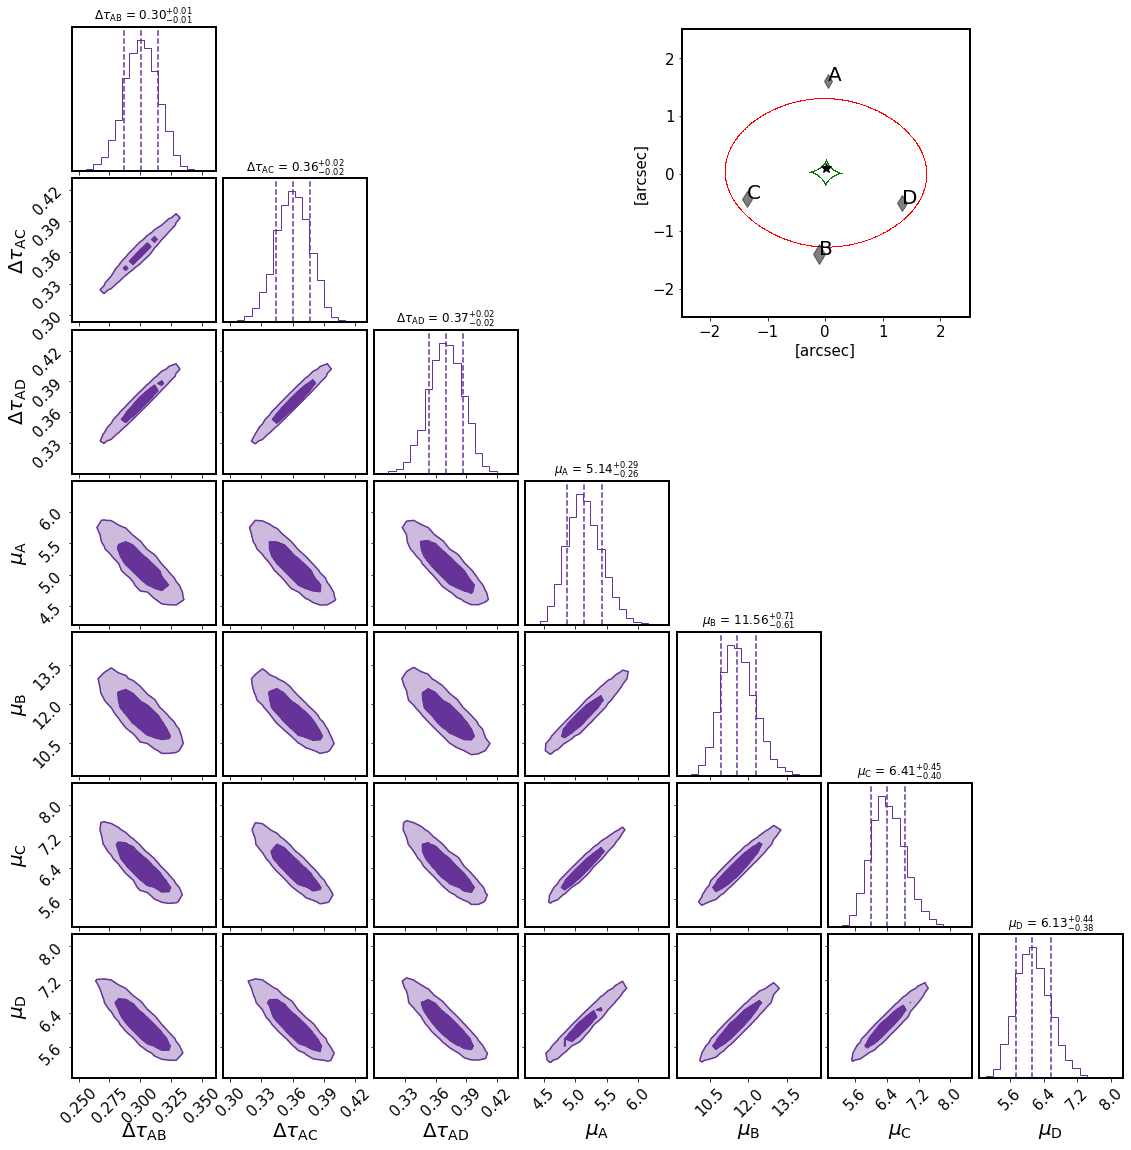

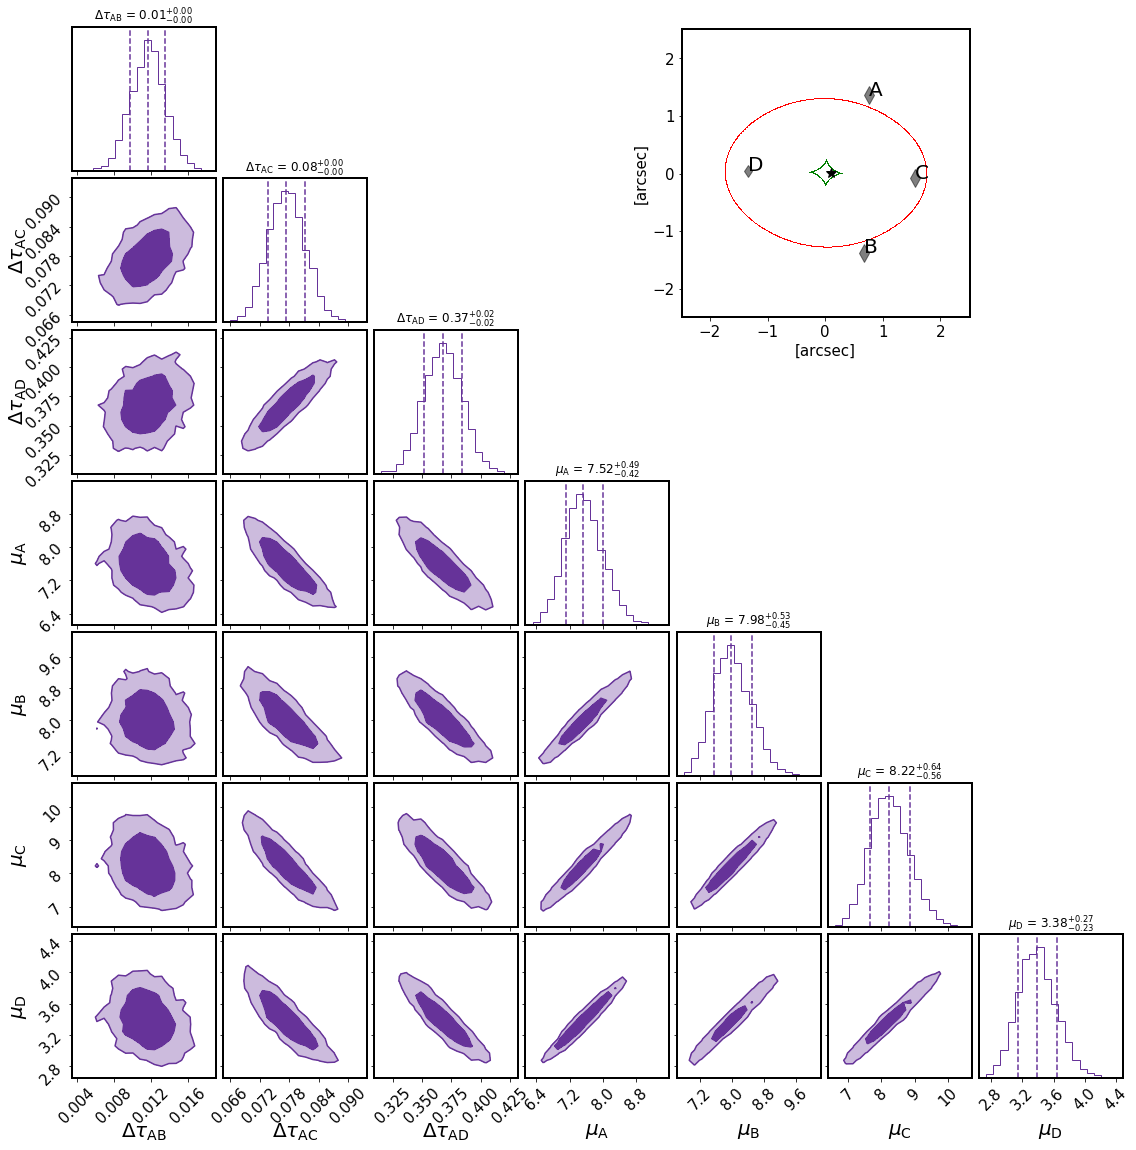

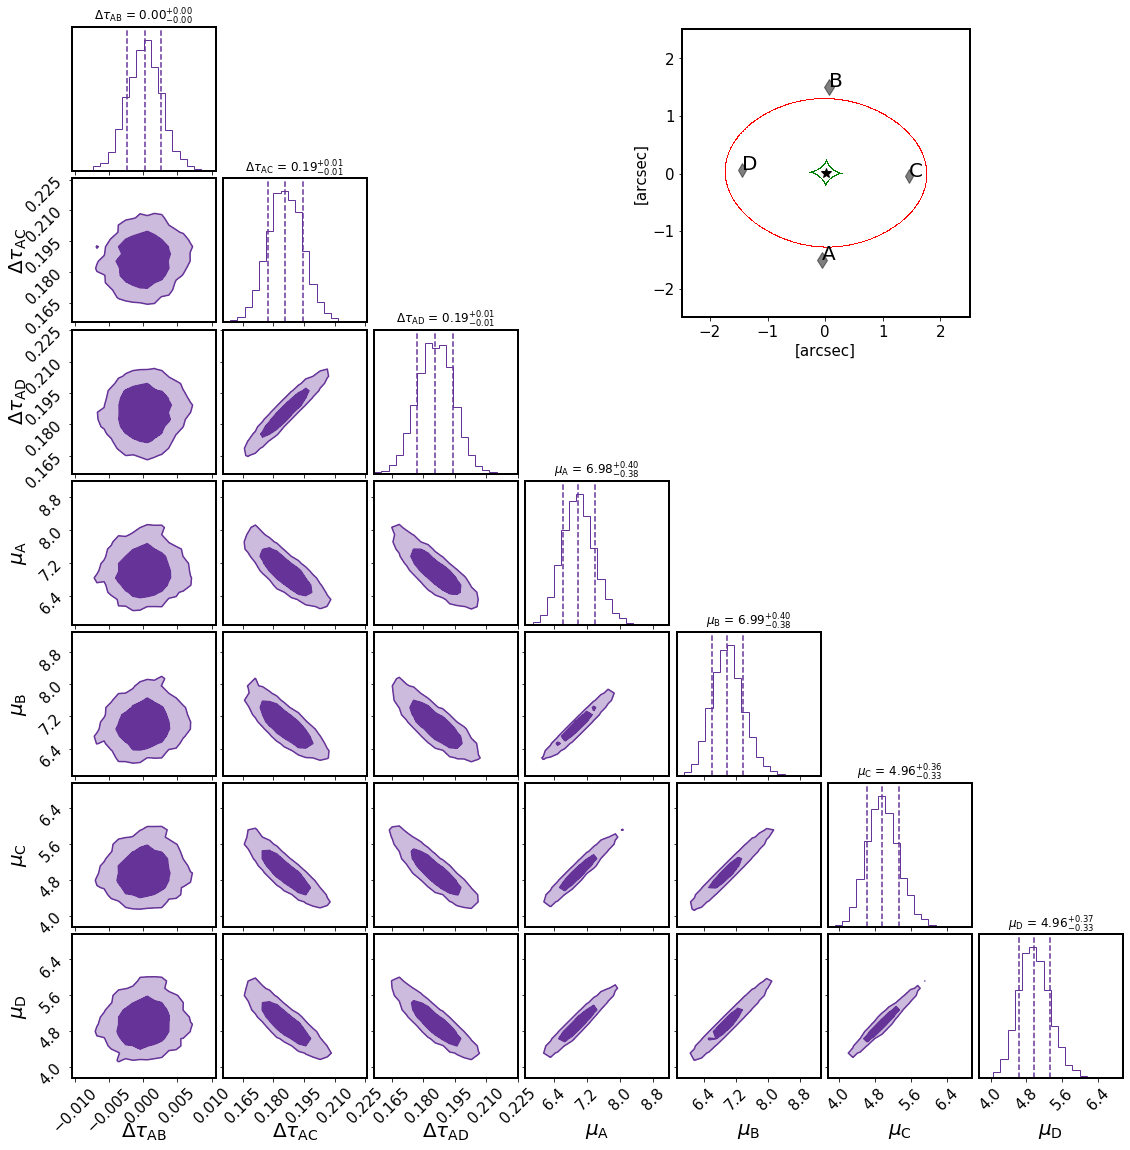

In [19]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes


def plot_lens(mcmc_chain, kwargs_ps):

    alpha = 0.8

    kwargs_corner = {'bins': 20, 'plot_datapoints': False, 'show_titles': True,  
                     'label_kwargs': dict(fontsize=20), 'smooth': 0.3, 'levels': [0.68,0.95],
                    'fill_contours': True, 'alpha': alpha}

    fig = corner.corner(mcmc_chain, labels=[r"$\Delta\tau_{\rm AB}$", r"$\Delta\tau_{\rm AC}$", r"$\Delta\tau_{\rm AD}$", r"$\mu_{\rm A}$", r"$\mu_{\rm B}$", r"$\mu_{\rm C}$", r"$\mu_{\rm D}$"],
                        quantiles=[0.16, 0.5, 0.84],
                        color='rebeccapurple', **kwargs_corner)

    parent_axes = fig.axes[11]
    inset_ax = inset_axes(parent_axes, width=4, height=4., loc=3)

    lens_plot.lens_model_plot(inset_ax, lens_model, kwargs_lens, numPix=500, deltaPix=0.01, 
                              sourcePos_x=kwargs_ps[0]['ra_source'], sourcePos_y=kwargs_ps[0]['dec_source'], **kwargs_lens_plot)
    inset_ax.set_xlabel('[arcsec]', fontsize=15)
    inset_ax.set_ylabel('[arcsec]', fontsize=15)
    return fig

save_plot = False
    
    
fig = plot_lens(mcmc_chain_fold, kwargs_ps_fold)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/fold_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()
fig = plot_lens(mcmc_chain_cusp, kwargs_ps_cusp)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/cusp_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()
fig = plot_lens(mcmc_chain_cross, kwargs_ps_cross)
if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/cross_image_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)
fig.show()


In [9]:


def draw_lens_likelihood(lens_config):
    """
    draw a mock lens, perform the modeling inference and assemple all the likelihood pieces
    """
    if lens_config == 'cusp':
        cov_model = cov_model_cusp
        kwargs_ps = kwargs_ps_cusp
    elif lens_config == 'cross':
        cov_model = cov_model_cross
        kwargs_ps = kwargs_ps_cross
    elif lens_config == 'fold':
        cov_model = cov_model_fold
        kwargs_ps = kwargs_ps_fold
    else:
        raise ValueError('lens_config %s not supported!' % lens_config)
    amp, mag_model, time_delay_diff, fermat_pot_pl_diff, x_image, y_image, z_lens, z_source, lambda_int_i = true_lens_sne(kwargs_lens, kwargs_ps)
    time_delay_measured, cov_td_measured, amp_measured, cov_amp_measured, x_image_measured, y_image_measured = draw_lens_measured(amp, time_delay_diff, x_image, y_image)

    model_true = np.append(fermat_pot_pl_diff, mag_model)
    model_mean = np.random.multivariate_normal(model_true, cov_model)
    n = len(x_image)
    fermat_diff = model_mean[:n]
    mag = model_mean[n:]

    kwargs_likelihood = {'z_lens': z_lens, 
                         'z_source': z_source, 
                         'likelihood_type': 'TDMag',
                         'time_delay_measured': time_delay_measured, 
                         'cov_td_measured': cov_td_measured,
                         'fermat_diff': fermat_diff,
                         'amp_measured': amp_measured, 
                         'cov_amp_measured': cov_amp_measured,
                         'magnitude_zero_point': magnitude_zero_point,
                         'magnification_model': mag,
                         'cov_model': cov_model,
                         'num_distribution_draws': 100}
    return kwargs_likelihood

kwargs_likelihood_list = []
for i in range(num_sne_cusp):
    kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='cusp'))
for i in range(num_sne_cross):
    kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='cross'))
for i in range(num_sne_fold):
    kwargs_likelihood_list.append(draw_lens_likelihood(lens_config='fold'))


## hierArc sampling settings
Here we specify the sampling settings for the inferences performed with hierArc

In [10]:
# sampling settings
n_walkers = 50
n_run = 100
n_burn = 100

kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {'lambda_mst': lambda_int_true_mean, 'lambda_mst_sigma': lambda_int_true_sigma},
                     'kwargs_source': {'mu_sne': mu_sne_ture, 'sigma_sne': sigma_sne_true}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.05},
                     'kwargs_lens': {'lambda_mst': 0.1, 'lambda_mst_sigma': 0.03},
                     'kwargs_source': {'mu_sne': 1, 'sigma_sne': 0}}


kwargs_bounds = {'kwargs_lower_cosmo': {'h0': 0, 'om': 0},
                'kwargs_lower_lens': {'lambda_mst': 0.5, 'lambda_mst_sigma': 0},
                 'kwargs_lower_source': {'mu_sne': 0, 'sigma_sne': 0},
                'kwargs_upper_cosmo': {'h0': 200, 'om': 1},
                'kwargs_upper_lens': {'lambda_mst': 1.5, 'lambda_mst_sigma': 0.5},
                'kwargs_upper_source': {'mu_sne': 100, 'sigma_sne': 2},
                'kwargs_fixed_cosmo': {},
                'kwargs_fixed_lens': {},
                'kwargs_fixed_source': {'sigma_sne': sigma_sne}}


class CustomPrior(object):
    def __init__(self, om_prior=False):
        self._om_prior = om_prior
        self.om_mean = kwargs_cosmo_true['om']
        self.sigma_om = sigma_om  # thight prior on Om based on the Pantheon flat LCDM constraints 
        
    def __call__(self, kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source):
        return self.log_likelihood(kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source)
    
    # not needed anymore for Pantheon sampling
    def log_likelihood(self, kwargs_cosmo, kwargs_lens, kwargs_kin, kwargs_source):

        logL = 0
        # a prior on Omega_m helps in constraining the MST parameter as the kinematics becomes less cosmology dependent...
        if self._om_prior is True:
            om = kwargs_cosmo.get('om', self.om_mean)
            logL += -(om - self.om_mean)**2 / self.sigma_om**2 / 2
        return logL

# joint options for hierArc sampling
kwargs_sampler = {'cosmology': cosmology, 'kwargs_bounds': kwargs_bounds,
                  'lambda_mst_sampling': True, 'lambda_mst_distribution': lambda_mst_distribution, 
                  'kappa_ext_sampling': False, 'kappa_ext_distribution': 'NONE', 
                  'alpha_lambda_sampling': False, 
                  'sne_likelihood': 'Pantheon', # we are using the Pantheon sample as the likelihood
                  'sne_apparent_m_sampling': True, 
                  'sne_distribution': 'GAUSSIAN',
                  'z_apparent_m_anchor': z_apparent_m_anchor,
                  'log_scatter': False,
                  'interpolate_cosmo': False,
                  'num_redshift_interp': 100, 'cosmo_fixed': None}



# Run forcasts
In the following blocks we run the inference for the single lens 'modeled' previously without taking into account the MST.

In [22]:


mcmc_sampler_sne_sl = MCMCSampler(kwargs_likelihood_list=kwargs_likelihood_list, custom_prior=CustomPrior(om_prior=False), **kwargs_sampler)
mcmc_samples_sne_sl, log_prob_cosmo_sne_sl = mcmc_sampler_sne_sl.mcmc_emcee(n_walkers, n_burn, n_run, kwargs_mean_start, kwargs_sigma_start)



100%|██████████| 200/200 [28:48<00:00,  8.56s/it]


(10000, 5)
(5000, 5)


/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/corner/core.py:660: UserWarning: The following kwargs were not used by contour: 'color'
  **contourf_kwargs,
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:53: MatplotlibDeprecationWarning: 
The frameon kwarg was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use facecolor instead.
/Users/sibirrer/Library/Python/3.6/lib/python/site-packages/ipykernel_launcher.py:55: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


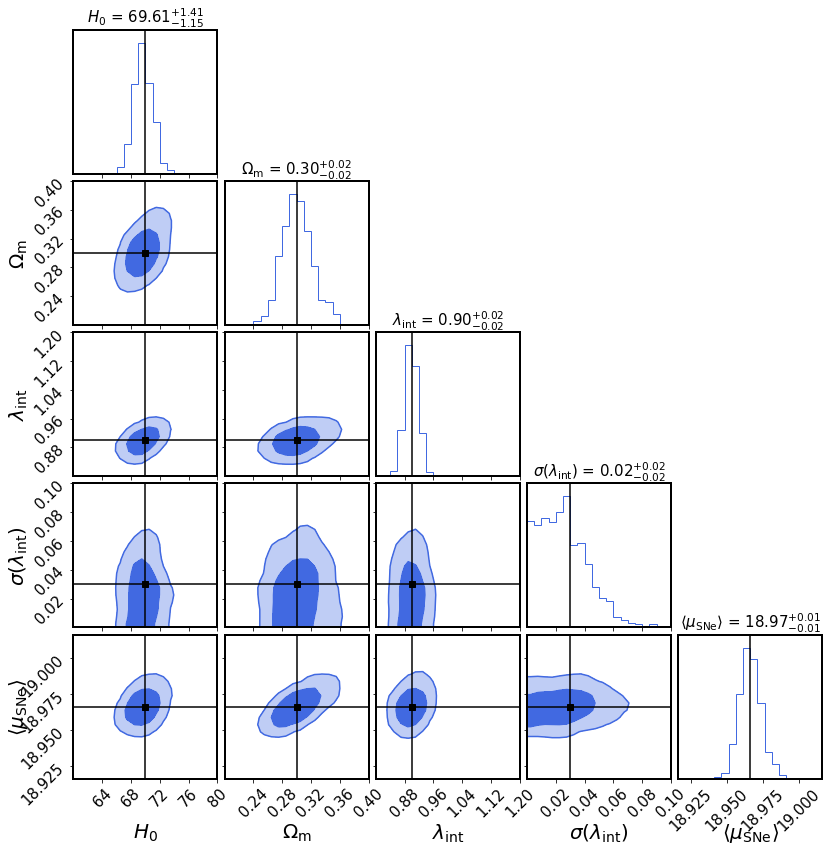

In [47]:

truths = mcmc_sampler_sne_sl.param.kwargs2args(kwargs_cosmo=kwargs_cosmo_true, kwargs_lens=kwargs_lens_true, kwargs_source=kwargs_source_true)

param_names_sne_sl=mcmc_sampler_sne_sl.param_names(latex_style=False)
param_names_sne=mcmc_sampler_sne.param_names(latex_style=False)

mcmc_samples_sne_extended = np.zeros((len(mcmc_samples_sne[:, 0]), len(mcmc_samples_sne_sl.T)))
print(np.shape(mcmc_samples_sne_extended))
print(np.shape(mcmc_samples_sne_sl))

j = 0
for i, param in enumerate(param_names_sne_sl):
    if param in param_names_sne:
        mcmc_samples_sne_extended[:, i] = mcmc_samples_sne[:, j]
        j += 1
    else:
        mcmc_samples_sne_extended[:, i] = np.random.normal(-1, 0.1, len(mcmc_samples_sne[:, 0]))


color_list = ['royalblue', 'coral', 'mediumvioletred', 'rebeccapurple', 'steelblue', 'crimson', 'g', 'purple', 'orange', 'r', 'k']
levels = [0.68,0.95]
alpha = 0.8
extents = [[60, 80], [0.2, 0.4], [0.8, 1.2], [0, 0.1], [mu_sne_true-0.05, mu_sne_true+0.05]]

kwargs_corner = {'bins': 20, 'alpha': 0.2, 'smooth': 0.9, 'smooth1d': None, 
                 'levels': levels, 'truths': truths, 'truth_color': 'k',
                 'fill_contours': True, 'plot_datapoints': False,}
                 #'range': extents}


#kwargs_corner = {'bins': 20, 'plot_datapoints': False, 'show_titles': True,  
#                 'truths': truths, 'truth_color': 'k',
#                 'label_kwargs': dict(fontsize=20), 'smooth': 0.3, 'levels': levels,
#                 'range': extents, quantiles=[0.16, 0.5, 0.84],
#                 'fill_contours': True, 'alpha': alpha}

#fig = corner.corner(mcmc_samples_sne_extended, color=color_list[1],
#                    hist_kwargs= {'density': True, 'color': color_list[1]}, **kwargs_corner)

fig = corner.corner(mcmc_samples_sne_sl, labels=mcmc_sampler_sne_sl.param_names(latex_style=True),
                    color=color_list[0],
                    range=extents,
                    show_titles=True,
                    hist_kwargs= {'density': True, 'color': color_list[0]},
                    title_kwargs=dict(fontsize=15),
                    label_kwargs=dict(fontsize=20),
                    contourf_kwargs={'color': color_list[0]},
                    **kwargs_corner)

if save_plot:
    fig.savefig('/Users/sibirrer/Science/Publications/glSNe/Plots/forecast_posteriors.pdf', dpi=None, facecolor='w', edgecolor='w',
            orientation='portrait', papertype=None, format='pdf',
            transparent=False, bbox_inches=None, pad_inches=0.1,
            frameon=None, metadata=None)

fig.show()

In [ ]:


#TODO
# overplot SNE-only posteriors (add blanck/offset outside plotting extent)
# make plot nice with alpha-scale

In [12]:
# make relative exansion history super well constrained (future best sample)